# AppStat project
Rune Ekman (njf458)


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from iminuit import Minuit
from iminuit.cost import LeastSquares


## Pendulum

Should we do the data processing for the laser and the tape measure separately? Troels said that it was quite hard to make them agree.

## Lengths

In [7]:
# Laser measurements from ceiling to floor  in meters
L_laser_s = [18.76, 18.76, 18.757, 18.759, 18.758, 18.758, 18.762, 18.758, 18.76, 18.758]
L_laser_s_toweight = [18.374, 18.378]
L_laser_m = [18.769, 18.764, 18.764, 18.763, 18.769, 18.759, 18.76, 18.758, 18.759, 18.759]
L_laser_r = [18.747, 18.749,18.780,18.774,18.790,18.784,18.771,18.780]
L_laser_a = [18.776,18.775,18.770,18.775,18.767,18.770]  

# Measured [to the top of weigth, to the bottom of the weigth] in meters
L_tape_s = [18.384, 18.416]
L_tape_m = [18.385, 18.415]
L_tape_r = [18.382, 18.419]
L_tape_a = [18.387, 18.416]

#From floor to weight in meters
floor_to_weight_r = [0.345, 0.345]
floor_to_weight_a = [0.346, 0.347, 0.347]

#Height of weight?

#Hook on the tape measure in centimeters
tape_hook_s = [3, 2.95, 3, 3]

#Lets put it together in a matrix
laser_measurements = [L_laser_s, L_laser_m, L_laser_r, L_laser_a]
tape_measurements = [L_tape_s, L_tape_m, L_tape_r, L_tape_a]


In [8]:
#Averages, laser
#Søren
sørenl = np.mean(L_laser_s)
sørenlsig = np.std(L_laser_s)#/np.sqrt(len(L_laser_s))
#Manon
manonl = np.mean(L_laser_m)
manonlsig = np.std(L_laser_m)#/np.sqrt(len(L_laser_m))
#Rune
runel = np.mean(L_laser_r)
runelsig = np.std(L_laser_r)#/np.sqrt(len(L_laser_r))
#Andreas
andreasl = np.mean(L_laser_a)
andreaslsig = np.std(L_laser_a)#/np.sqrt(len(L_laser_a))

combinedl = np.array([sørenl,manonl,runel,andreasl])
combinedlsig = np.array([sørenlsig, manonlsig, runelsig, andreaslsig])

print("Lengths (Avg) of Søren, manon, rune, andreas",sørenl, manonl, runel, andreasl)
print("stds, same order ",sørenlsig, manonlsig, runelsig, andreaslsig)


#Calculating weighted average of all the lengths to the floor
weights = 1/combinedlsig**2
avglengthtobottom = np.sum(combinedl*weights)/np.sum(weights)
unctobottom = np.sqrt(1/np.sum(weights))
print("Weighted average for each person, to the bottom",avglengthtobottom, "+-", unctobottom)

#Calculating

#Distance to COM (weighted) using laser



Lengths (Avg) of Søren, manon, rune, andreas 18.759 18.762400000000003 18.771875 18.772166666666667
stds, same order  0.0014142135623735673 0.003903844259187956 0.014810785765785876 0.0033374973990832556
Weighted average for each person, to the bottom 18.76121809716788 +- 0.0012309605230866052


## Timing

In [68]:
def ALL(file, bins):
    
    #Defining our data, first for the period
    testfile1 = file #These files should include ONLY the counts and the times.
    
    testdata1 = np.genfromtxt(file, delimiter='\t', names=('n', 't_s'))
    testdata1 = testdata1[::2]
    constant = testdata1[0][1]
    for i in range(len(testdata1)):
        testdata1[i][0] = i
        testdata1[i][1] = testdata1[i][1] - constant
    n1,t1 = testdata1["n"], testdata1["t_s"] #Defines my two arrays from the data
    sigt1 = 1 #Our uncertainty in elapsed time.


    # Length data
    #write up some array of the measurements we have made for the length
    #Defining straight line function to be used in fitting
    def line(x,a,b):
        y= a*x+b
        return y

    #Defining chi2 function for line:
    def chi2_owncalc_line(a,b) :
        y_fit = line(n1,a,b) #observe that we in this function input our data (n1 and t1)!!
        chi2 = np.sum(((t1 - y_fit) / sigt1)**2)
        return chi2
    
    #Performing the actual fit
    m = Minuit(chi2_owncalc_line,a=8, b=0)
    m.errordef = 1.0     # This is the definition for ChiSqaure fits
    m.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

    print('PERIOD VALUES')
    if (not m.fmin.is_valid) :
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

    # Loop to get both parameter values and uncertainties:
    for name in m.parameters :
        value, error = m.values[name], m.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value_line = m.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value_line = len(n1) - m.nfit

    Prob_value = stats.chi2.sf(chi2_value_line, Ndof_value_line) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value_line:.1f}   Ndof = {Ndof_value_line:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")
    
    # Plotting
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8), gridspec_kw={'height_ratios':[4,1]}, sharex=True)
    ax[0].errorbar(n1, t1, yerr=sigt1, color='k', fmt='o', label="Data")
    ax[0].set_xlabel('Timing measurement number', fontsize=18)
    ax[0].set_ylabel('Time elapsed (s)', fontsize=18)
    ax[0].set(xlim=(0, n1[-1]+np.ediff1d(n1)[0]), ylim=(0, t1[-1]+np.ediff1d(t1)[0]))
    #Enter the fit
    ax[0].plot(n1, line(n1, *m.values), label="Fit")

    fit_info = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {Ndof_value_line:.0f} = {m.fval/Ndof_value_line:.1f}",
    ]
    for p, v, e in zip(m.parameters, m.values, m.errors):
        fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

    ax[0].legend(title="\n".join(fit_info), frameon=False)


    #Create residual plot
    residual = line(n1,m.values[0], m.values[1]) - t1
    ax[1].scatter(n1,residual, color="k")
    ax[1].axhline(y=0, linestyle="dashed", color="red")
    ax[1].set_ylabel("Residuals", fontsize=18)
    
    fig, ax = plt.subplots(figsize=(10, 6))

    xmin=-0.2
    xmax=0.2
    Nbins = bins
    counts, bin_edges = np.histogram(residual, bins=Nbins, range=(xmin,xmax))
    x = (bin_edges[1:] + bin_edges[:-1])/2
    y = counts

    # Making sure non-zero bins
    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    sy=np.sqrt(y)


    #Plotting histogram
    hist = ax.hist(residual, bins=Nbins, histtype='step', linewidth=2, color='red', label='Residuals')

    #Creating Gaussian fit
    #First defining the Gauss function
    def gauss_pdf(val,A,mu,sigma):
        return A*stats.norm.pdf(val,mu,sigma)


    # Defining Chi2 calculation:
    def chi2_owncalc(A, mu, sigma) :
        y_fit = gauss_pdf(x, A, mu, sigma)
        chi2 = np.sum(((y - y_fit) / sy)**2)
        return chi2

    #Performing the actual fit
    minuit_chi2 = Minuit(chi2_owncalc,A=5, mu=0, sigma=0.05)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

    print('RESIDUAL GAUSSIAN VALUES')
    if (not minuit_chi2.fmin.is_valid) :
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

    # Loop to get both parameter values and uncertainties:
    for name in minuit_chi2.parameters :
        value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    N_NotEmptyBin = np.sum(y > 0)
    Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

    Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")

    x_axis = np.linspace(xmin, xmax, 1000)
    ax.plot(x_axis, gauss_pdf(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 
    ax.legend()

    def g(T, L, sig_T, sig_L):
    
    
        g=L*(2*np.pi/T)**2
        sig_g = np.sqrt((2*np.pi/T)**4 * sig_L**2 + ((2*L*(2*np.pi)**2)/T**3)**2 * sig_T**2)
    
        return g, sig_g
    print('g value =', g(m.values['a'], 18.4, m.errors['a'], 0.001))
 

PERIOD VALUES
Fit value: a = 8.19037 +/- 0.02774
Fit value: b = -8.61293 +/- 0.41231
Chi2 value: 20.1   Ndof = 23    Prob(Chi2,Ndof) = 0.634
RESIDUAL GAUSSIAN VALUES
Fit value: A = 4.70830 +/- 45.09619
Fit value: mu = 0.00063 +/- 0.09773
Fit value: sigma = 0.03085 +/- 0.05462
Chi2 value: 2.0   Ndof = -1    Prob(Chi2,Ndof) =   nan
g value = (10.828557692174021, 0.07333975365780954)
PERIOD VALUES
Fit value: a = 8.59434 +/- 0.04543
Fit value: b = -8.51189 +/- 0.49176
Chi2 value: 0.1   Ndof = 16    Prob(Chi2,Ndof) = 1.000
RESIDUAL GAUSSIAN VALUES
Fit value: A = 1.55172 +/- 0.40627
Fit value: mu = 0.00703 +/- 0.02587
Fit value: sigma = 0.08024 +/- 0.02514
Chi2 value: 0.0   Ndof = 1    Prob(Chi2,Ndof) = 0.826
g value = (9.83451465994929, 0.10397512263478208)


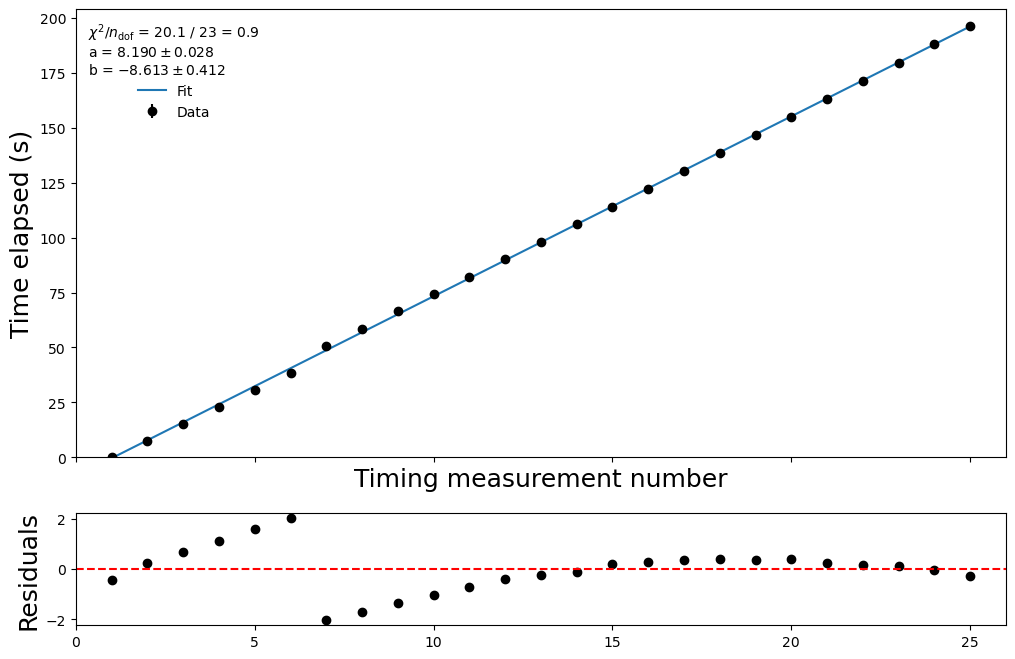

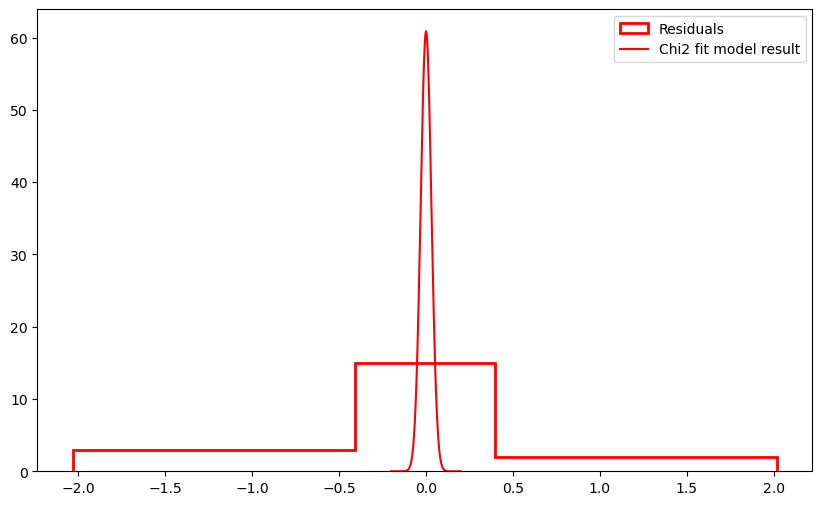

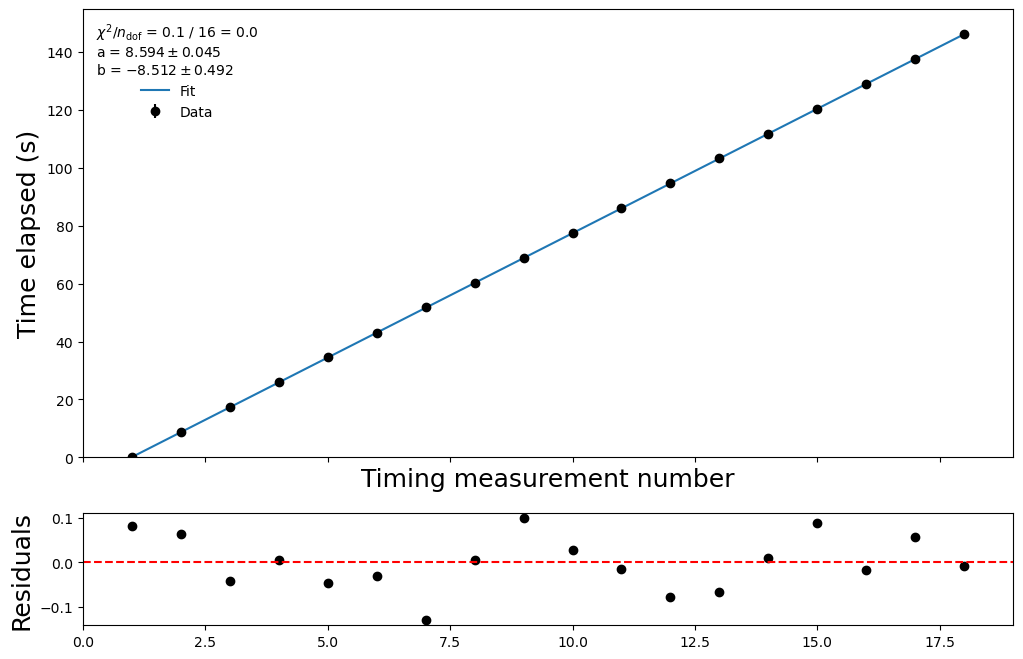

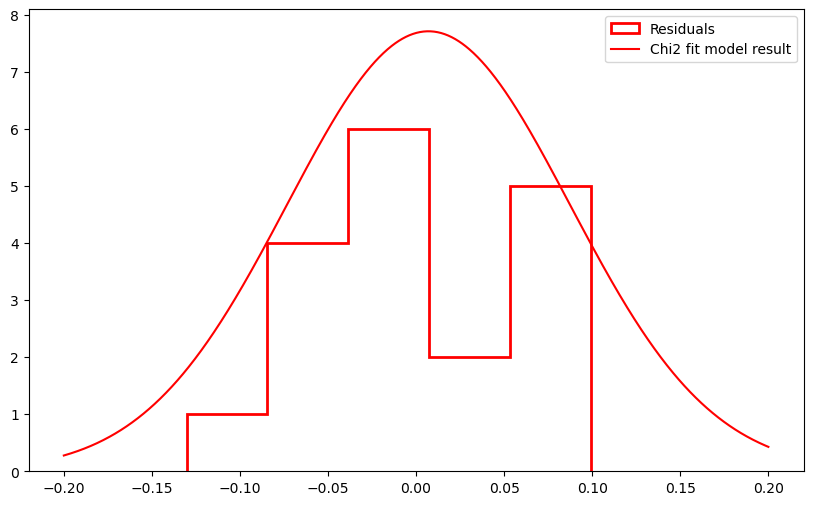

In [67]:
def visuals(file, ):
    



## Gaussian errors?
Below, we will look at a histogram of the residuals to determine whether our errors are Gaussian. If Gaussian, the standard deviation should give the typical uncertainty.
No matter if it is Gaussian or not, it should be centered around zero! Otherwise something is wrong in our experimental method.

We must be careful when fitting to a histogram though, due to the binning. We need to make sure that no bins are empty, and we need to fit to the bin centers.
When we have fitted, we will have some typical uncertainty. We can use this to redo our linefit (this will, by construction, make it a "good" fit in terms of chi square. We argue that this is valid as we are sure in the linear relationship. If the data shows some non-linearity, or we were somehow unsure about the relation between x and y, then this method is of course flawed!)

The datacount is low here, and as such the fit is mediocre at best.
When putting in our own data, we should make sure to get enough data points!

We should now be able to redo the linear fit, this time using the sigma from the residual Gauss fit as the uncertainty on the datapoints. See previous text. 